[View in Colaboratory](https://colab.research.google.com/github/sergeivolodin/ProbabilisticNeuronFailureCode/blob/master/DropoutErrorVarianceKerasColab.ipynb)

In [1]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers.core import Lambda
from keras.optimizers import SGD
from keras.initializers import Constant
from keras import backend as K
from keras.utils import plot_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
%matplotlib inline
from matplotlib import pyplot as plt

Using TensorFlow backend.


In [0]:
def PermanentDropout(p_fail):
  """ Make dropout work using predict() """
  return Lambda(lambda x: K.dropout(x, level=p_fail))
  
def create_model(p_fails, layer_weights, layer_biases):
  """ Create some simple network """
  assert(len(p_fails) == len(layer_weights))
  assert(len(layer_biases) == len(layer_weights))
  
  model = Sequential()
  for i, (p_fail, w, b) in enumerate(zip(p_fails, layer_weights, layer_biases)):
    is_last = i + 1 == len(p_fails)
    model.add(Dense(w.shape[1], input_shape = (w.shape[0], ),
                    kernel_initializer = Constant(w),
                    activation = 'linear' if is_last else 'sigmoid',
                    bias_initializer = Constant(b)))
    if not is_last and p_fail > 0:
      model.add(PermanentDropout(p_fail))
  
  model.compile(loss='binary_crossentropy', optimizer = 'sgd')
  #model.summary()
  return model

class Experiment():
  def __init__(self, N, P):
    assert(len(N) == len(P) + 1)
    self.N = N + [1]
    self.P = P + [0]
    self.model = None
    self.init_weights()
  def init_weights(self):
    self.W = []
    self.B = []
    for i in range(1, len(self.N)):
      w = np.random.randn(self.N[i - 1], self.N[i])
      b = np.random.randn(self.N[i])
      self.W.append(w)
      self.B.append(b)
    self.model = create_model(self.P, self.W, self.B)
    self.model_no_dropout = create_model([0] * len(self.P), self.W, self.B)
  def predict_no_dropout(self, data):
    return self.model_no_dropout.predict(np.array([data]))[0][0]
  def predict(self, data, repetitions = 100):
    data = np.repeat(np.array([data]), repetitions, axis = 0)
    return self.model.predict(data).T[0]
  def plot_error(experiment, inp, repetitions = 100):
    results = experiment.predict(inp, repetitions = repetitions)
    true = experiment.predict_no_dropout(inp)
    plt.title('Network error P=' + ', '.join([str(v) for v in experiment.P[:-1]]) +
              ' N=' + ', '.join([str(v) for v in experiment.N[:-1]]))
    plt.xlabel('Network output')
    plt.ylabel('Frequency')
    plt.hist(results, density = True)
    plt.plot([true, true], [0, 1], label = 'True value')
    plt.legend()
    plt.show()
    return results - true
  def get_error(experiment, inp, repetitions = 100):
    return experiment.predict(inp, repetitions = repetitions) - experiment.predict_no_dropout(inp)
  def get_mean_error(self):
    pass
    #C = 1
    #K = ...
  def get_std_error(self):
    pass

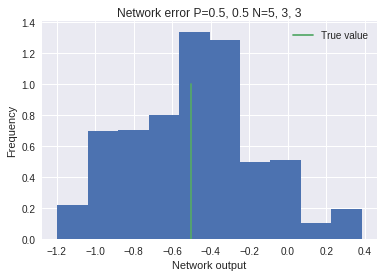

array([ 0.73687357, -0.04692471,  0.04456872, ..., -0.27754414,
        0.13859552, -0.34103817], dtype=float32)

In [74]:
experiment = Experiment([5, 3, 3], [0.5, 0.5])
experiment.plot_error(np.zeros(5), repetitions = 10000)